In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ship-exhaust/scikitlearn/default/5/evaluation_base_report.csv
/kaggle/input/ship-exhaust/scikitlearn/default/5/evaluation_report.csv
/kaggle/input/ship-exhaust/scikitlearn/default/5/ship_emission_lgbm_minimal.pkl
/kaggle/input/ship-exhaust/scikitlearn/default/5/tuning_model.csv
/kaggle/input/ship-data-full-details/Ship_Data_Full_Details.csv
/kaggle/input/ship-data-full-details/final_emissions_with_base.csv
/kaggle/input/ship-data-full-details/data_ship_emissions.csv
/kaggle/input/ship-data-full-details/Ship_Data.csv
/kaggle/input/ship-data-full-details/Ship_emissions.csv


In [2]:
!pip install -q shap
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
import joblib, os
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
import pandas as pd
import numpy as np
import time
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
n_model = 10

In [4]:
file_path = '/kaggle/input/ship-data-full-details/final_emissions_with_base.csv'
df = pd.read_csv(file_path)
df

,month,type,year_ship,buoy,time_port,time_anchor,time_trip,time_maneuver,v_trip,v_maneuver,...,E2_CH4,E3_CH4,E4_CH4,E5_CH4,Total_CH4,E1_base_CH4,E2_base_CH4,E3_base_CH4,E4_base_CH4,E5_base_CH4
0,7,container_ship,1994,0,212.16,208,0.24,3.92,9.87,7.72,...,281.165835,1.222512,73.726866,3912.037762,4304.126854,35.973880,281.165835,1.222512,73.726866,3912.037762
1,12,container_ship,2022,0,33.47,29,0.24,4.23,9.87,7.15,...,408.619947,1.847464,120.227269,824.253145,1415.932929,60.985104,408.619947,1.847464,120.227269,824.253145
2,6,container_ship,1990,0,233.44,229,0.25,4.19,9.42,7.22,...,390.028779,2.019389,124.966014,6829.884795,7398.583887,51.684909,390.028779,2.019389,124.966014,6829.884795
3,7,container_ship,2007,0,59.59,55,0.25,4.34,9.63,6.97,...,256.154004,1.280474,82.076431,1040.139106,1418.566352,38.916337,256.154004,1.280474,82.076431,1040.139106
4,7,container_ship,2021,0,126.21,122,0.25,3.96,9.54,7.65,...,235.471537,1.608914,94.099172,2899.014907,3257.855709,38.959407,318.204780,1.608914,94.099172,2899.014907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,3,container_ship,2013,0,113.34,109,0.24,4.10,9.81,7.39,...,871.169967,3.357468,211.778772,5630.216124,6801.983813,89.022377,650.126841,3.357468,211.778772,5630.216124
690,3,container_ship,2008,0,79.44,75,0.23,4.21,10.27,7.20,...,506.355870,2.871215,194.051897,3456.981531,4228.295675,68.035162,429.115144,2.871215,194.051897,3456.981531
691,6,container_ship,2005,0,138.53,134,0.22,4.31,10.63,7.02,...,288.374843,1.366061,98.814945,3072.204797,3501.322771,40.562125,228.868923,1.366061,98.814945,3072.204797
692,8,container_ship,2017,0,70.06,66,0.23,3.83,10.20,7.91,...,225.206624,0.821616,50.517039,870.528614,1171.115704,24.785371,192.484294,0.821616,50.517039,870.528614


In [5]:
feature_cols = [
    # 'type', 
    'year_ship', 'rpm', 'is_man', 'valve_type',
    'P_main', 'P_aux',
    'v_trip', 'v_maneuver', 'v_max',
    'time_anchor' 
]
target_cols = [col for col in df.columns if col not in feature_cols 
               and col not in ['buoy', 'time_port', 'time_trip', 'time_maneuver', 'month', 'type']
               and 'base' not in col and 'Total' not in col
              ]

target_base_cols = [col for col in df.columns if col not in feature_cols 
               and col not in ['buoy', 'time_port', 'time_trip', 'time_maneuver', 'month', 'type']
               and 'base' in col 
              ]

print(f"Input Features: {len(feature_cols)}")
print(f"   List: {feature_cols}")

X = df[feature_cols].copy()
y = df[target_cols].copy()
y_base = df[target_base_cols].copy()


Input Features: 10
   List: ['year_ship', 'rpm', 'is_man', 'valve_type', 'P_main', 'P_aux', 'v_trip', 'v_maneuver', 'v_max', 'time_anchor']


In [6]:
encoders = {}

le_type = LabelEncoder()
# X['type'] = le_type.fit_transform(X['type'].astype(str))
# encoders['type'] = le_type

le_valve = LabelEncoder()
X['valve_type'] = le_valve.fit_transform(X['valve_type'].astype(str))
encoders['valve_type'] = le_valve

X['is_man'] = X['is_man'].astype(int)

cat_features = [
    # 'type', 
                'valve_type', 'is_man']
for col in cat_features:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test, y_base_train, y_base_test = train_test_split(X, y, y_base, test_size=0.2, random_state=42)


In [7]:
y_test.columns

Index(['E1_PM10', 'E2_PM10', 'E3_PM10', 'E4_PM10', 'E5_PM10', 'E1_PM2.5',
       'E2_PM2.5', 'E3_PM2.5', 'E4_PM2.5', 'E5_PM2.5', 'E1_NOx', 'E2_NOx',
       'E3_NOx', 'E4_NOx', 'E5_NOx', 'E1_SOx', 'E2_SOx', 'E3_SOx', 'E4_SOx',
       'E5_SOx', 'E1_CO', 'E2_CO', 'E3_CO', 'E4_CO', 'E5_CO', 'E1_HC', 'E2_HC',
       'E3_HC', 'E4_HC', 'E5_HC', 'E1_CO2', 'E2_CO2', 'E3_CO2', 'E4_CO2',
       'E5_CO2', 'E1_N2O', 'E2_N2O', 'E3_N2O', 'E4_N2O', 'E5_N2O', 'E1_CH4',
       'E2_CH4', 'E3_CH4', 'E4_CH4', 'E5_CH4'],
      dtype='object')

--- SHAP for: E1_CO2 (Index: 30) ---


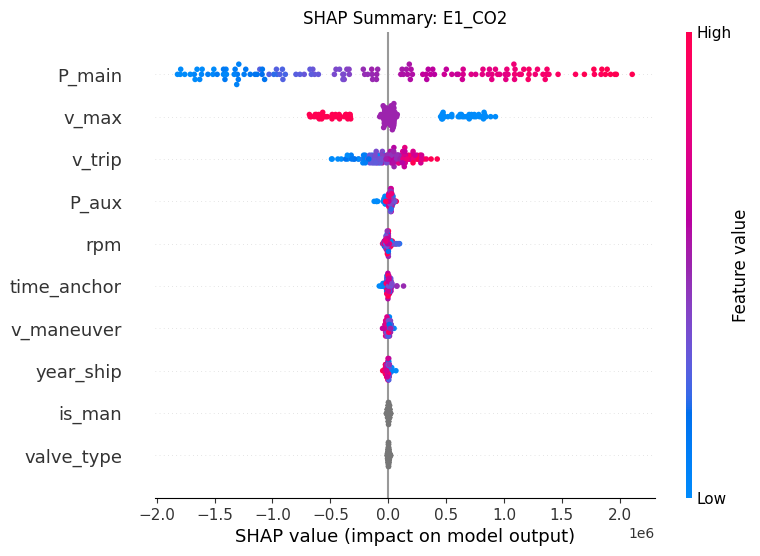

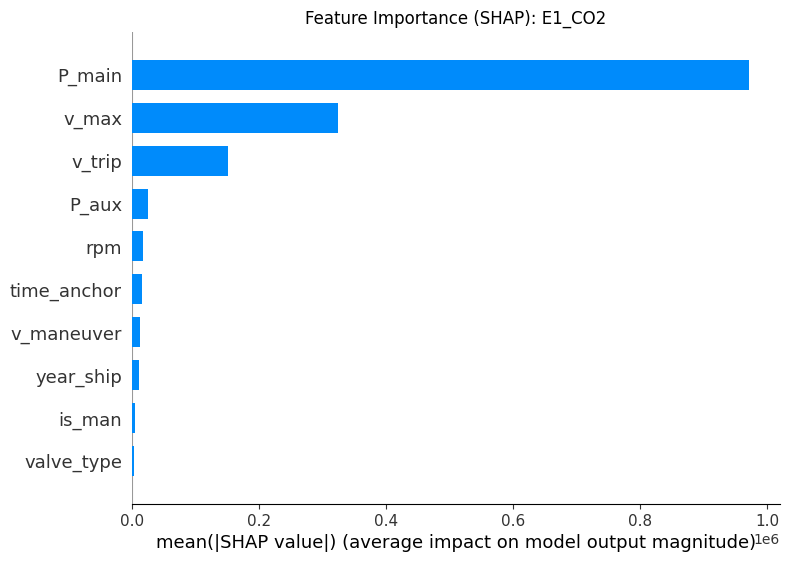

--- SHAP for: E2_CO2 (Index: 31) ---


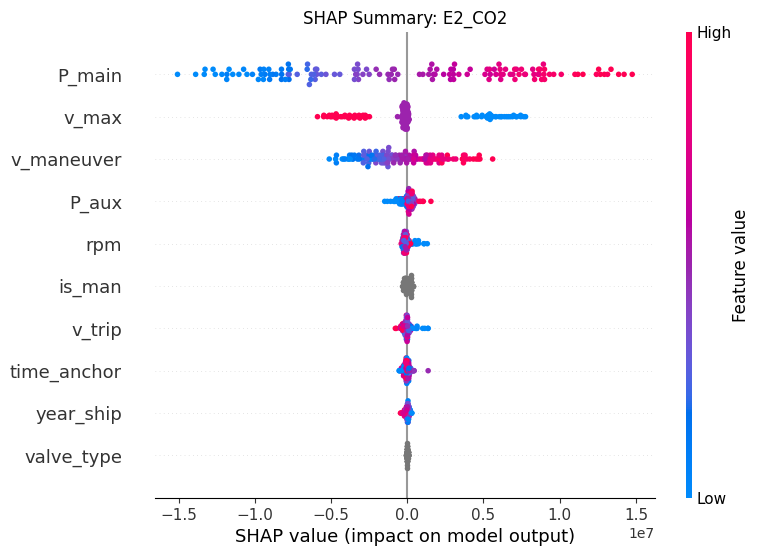

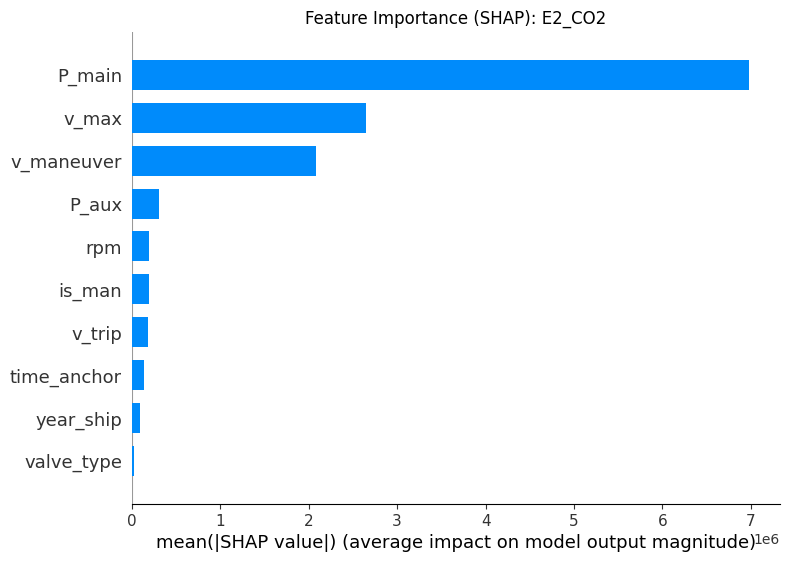

--- SHAP for: E3_CO2 (Index: 32) ---


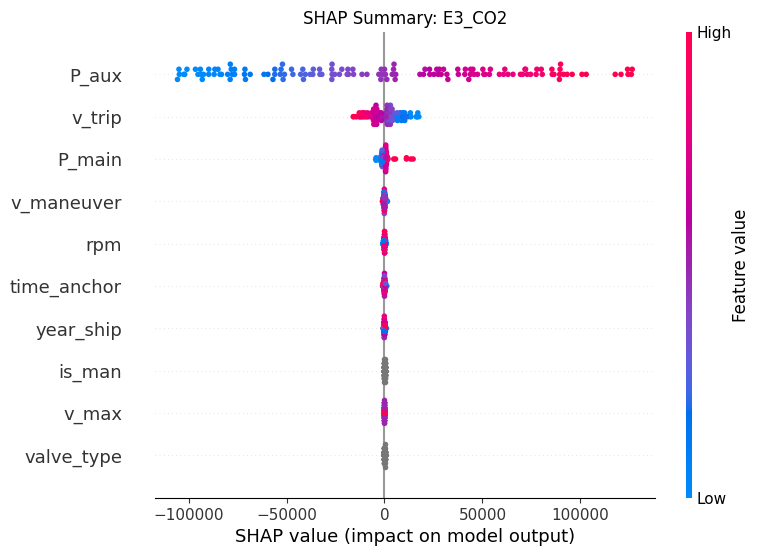

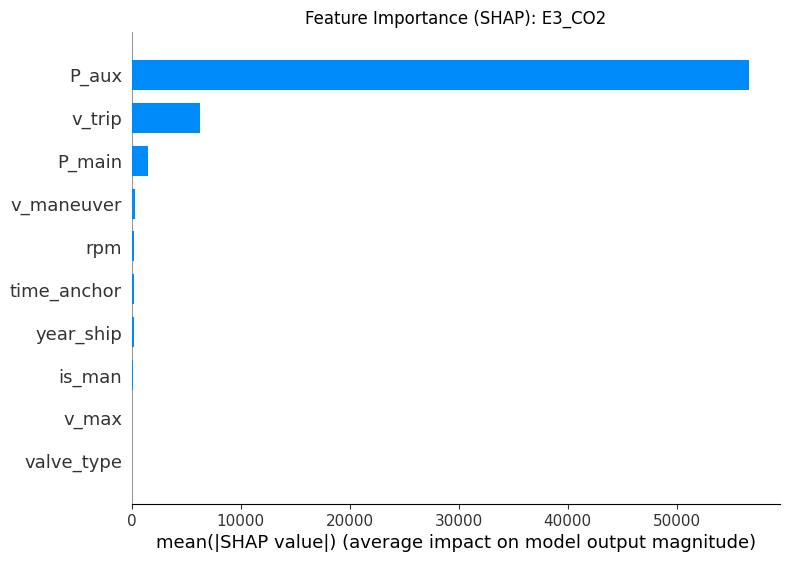

--- SHAP for: E4_CO2 (Index: 33) ---


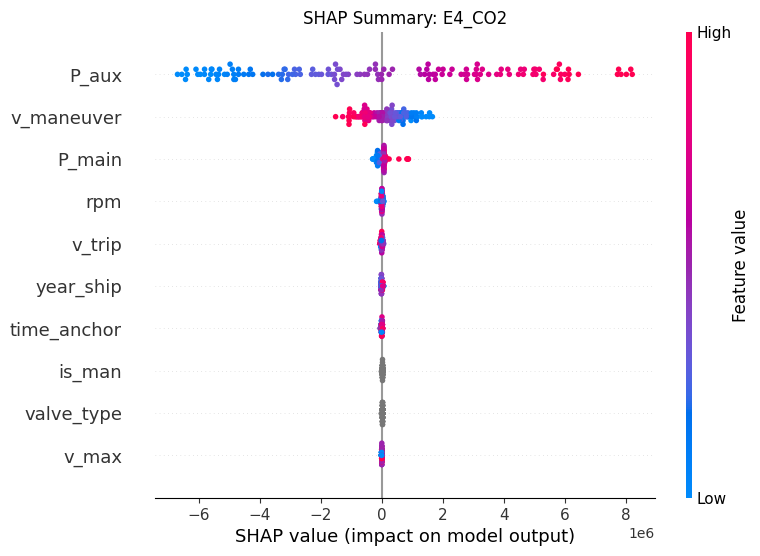

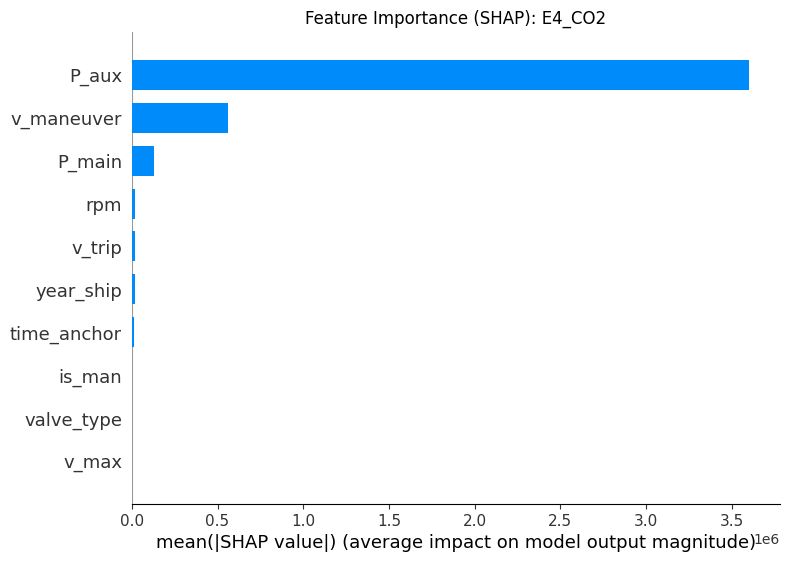

--- SHAP for: E5_CO2 (Index: 34) ---


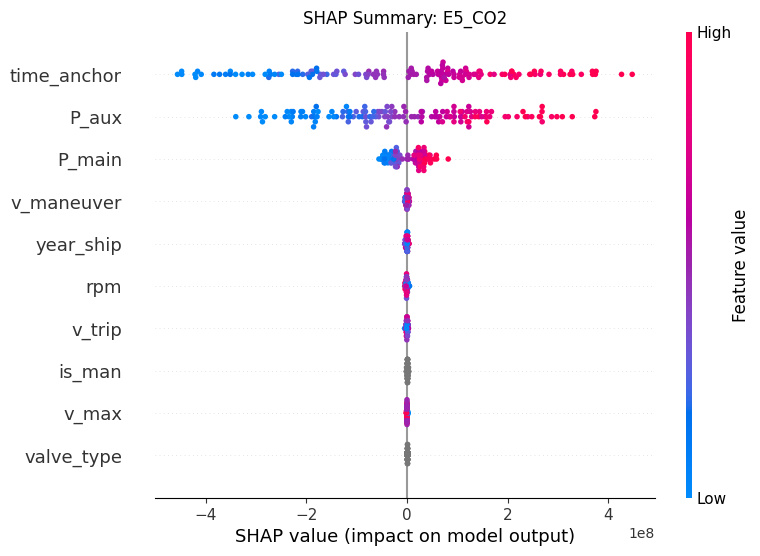

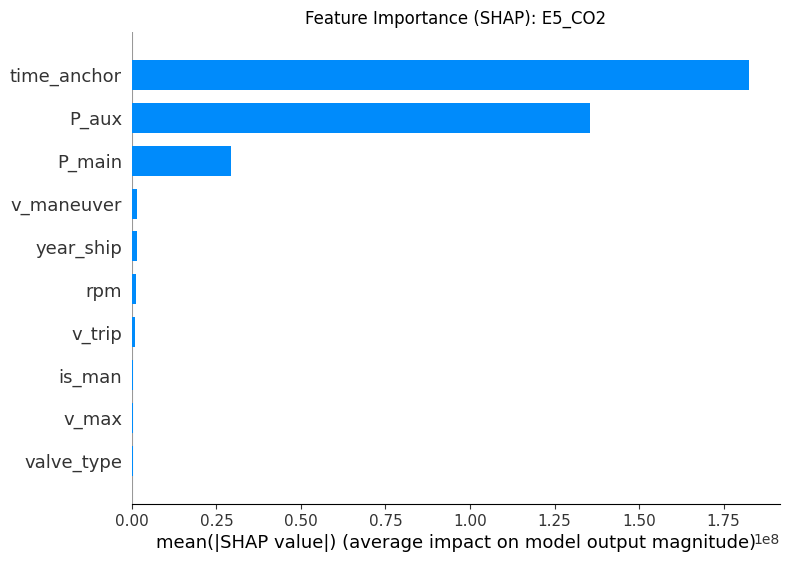

In [8]:
targets = ['E1_CO2', 'E2_CO2', 'E3_CO2', 'E4_CO2', 'E5_CO2']
try:
    model = best_model
except:
    VERSION=5
    MODEL_PATH = f'/kaggle/input/ship-exhaust/scikitlearn/default/{VERSION}/ship_emission_lgbm_minimal.pkl'
    
    def load_prediction_assets(path):
        if not os.path.exists(path):
            return None
        return joblib.load(path)
    
    assets = load_prediction_assets(MODEL_PATH)

    model=assets['model']

target_names = list(y_test.columns) 

def plot_shap_by_name(model, X_data, target_list, column_name):
    if column_name not in target_list:
        print(f"Lỗi: '{column_name}' doesn't exist!")
        return
    
    idx = target_list.index(column_name)
    
    sub_model = model.estimators_[idx]
    
    print(f"--- SHAP for: {column_name} (Index: {idx}) ---")
    
    explainer = shap.TreeExplainer(sub_model)
    shap_values = explainer.shap_values(X_data)
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_data, plot_type="dot", show=False)
    plt.title(f"SHAP Summary: {column_name}")
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f"Feature Importance (SHAP): {column_name}")
    plt.show()

for t in targets:
    plot_shap_by_name(model, X_test, target_names, t)


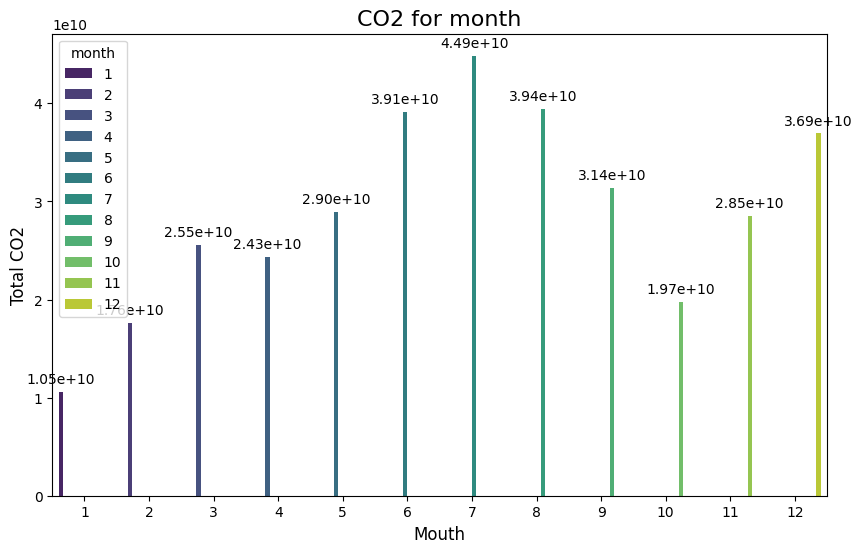

                   mean           std           min           50%  \
P_main     3.531741e+04  1.383752e+04  1.082674e+04  3.511461e+04   
rpm        1.145285e+02  9.512212e+00  9.290000e+01  1.138000e+02   
v_trip     1.002906e+01  5.078394e-01  8.320000e+00  1.003000e+01   
Total_CO2  4.998165e+08  3.086162e+08  3.701307e+07  4.402329e+08   
Total_NOx  7.106812e+06  5.791258e+06  2.160182e+05  5.701736e+06   

                    max      skew  
P_main     6.463074e+04  0.055541  
rpm        1.370000e+02  0.111725  
v_trip     1.155000e+01 -0.085216  
Total_CO2  1.572932e+09  0.799894  
Total_NOx  2.684714e+07  0.988943  


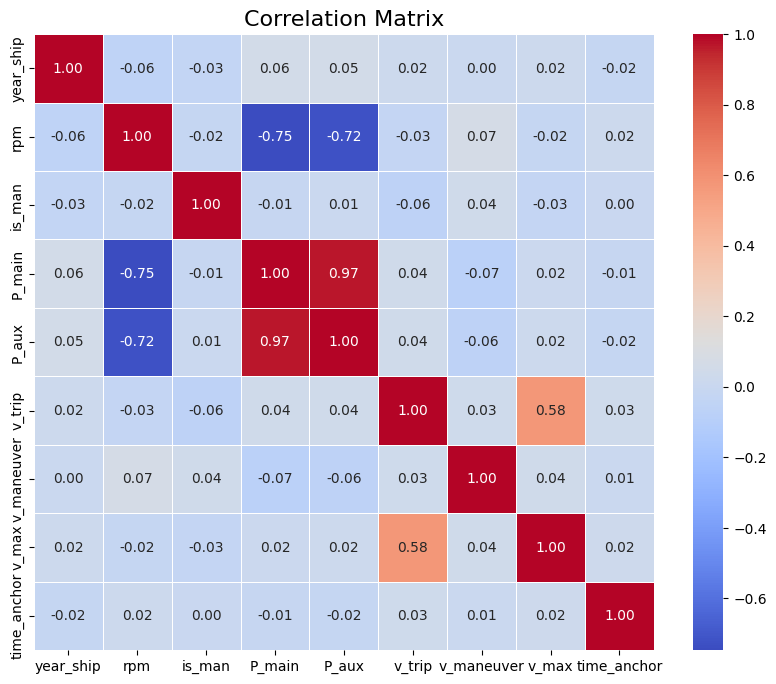

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


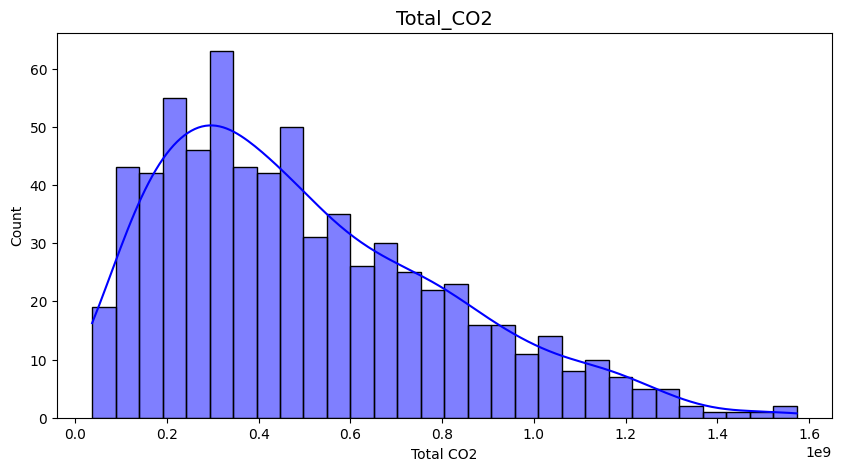

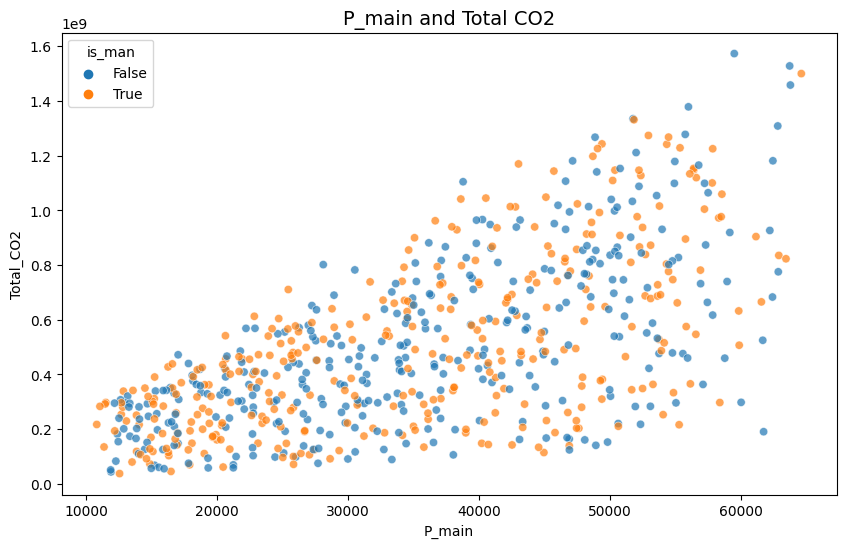

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
The figure layout has changed to tight


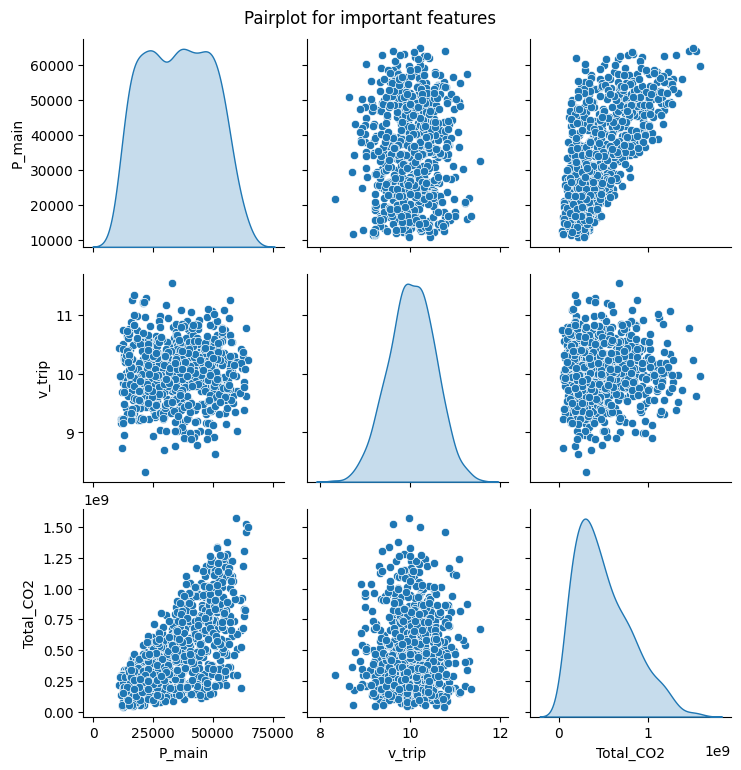

In [9]:
def plot_monthly_co2(df):
    monthly_co2 = df.groupby('month')['Total_CO2'].sum().reset_index()
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='month', y='Total_CO2', data=monthly_co2, palette='viridis', hue='month')
    
    plt.title('CO2 for month', fontsize=16)
    plt.xlabel('Mouth', fontsize=12)
    plt.ylabel('Total CO2', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2e}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    plt.show()

def print_statistics(df):
    cols = ['P_main', 'rpm', 'v_trip', 'Total_CO2', 'Total_NOx']
    stats = df[cols].describe().T
    
    stats['skew'] = df[cols].skew()
    stats['kurtosis'] = df[cols].kurt()
    
    print(stats[['mean', 'std', 'min', '50%', 'max', 'skew']])

def plot_heatmap(df):
    focus_cols = [  'year_ship', 'rpm', 'is_man',
    'P_main', 'P_aux',
    'v_trip', 'v_maneuver', 'v_max',
    'time_anchor']
    
    valid_cols = [c for c in focus_cols if c in df.columns]
    
    corr_matrix = df[valid_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

def ml_exploration(df):
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Total_CO2'], kde=True, color='blue', bins=30)
    plt.title('Total_CO2', fontsize=14)
    plt.xlabel('Total CO2')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='P_main', y='Total_CO2', data=df, hue='is_man', alpha=0.7)
    plt.title('P_main and Total CO2', fontsize=14)
    plt.show()

    subset = df[['P_main', 'v_trip', 'Total_CO2']]
    sns.pairplot(subset, diag_kind='kde')
    plt.suptitle("Pairplot for important features", y=1.02)
    plt.show()

if __name__ == "__main__":
    plot_monthly_co2(df)
    
    print_statistics(df)
    
    plot_heatmap(df)
    
    ml_exploration(df)

In [10]:

def mape_scorer(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

scoring_metrics = {
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': make_scorer(mape_scorer, greater_is_better=False)
}

print("Tuning")

lgbm_gpu = lgb.LGBMRegressor(
    device='gpu',
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)
multi_model = MultiOutputRegressor(lgbm_gpu)

param_dist = {
    'estimator__n_estimators': [500, 1000, 1500],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__num_leaves': [31, 63, 127],
    'estimator__max_depth': [-1, 10, 15],
    'estimator__min_child_samples': [20, 50],
    'estimator__subsample': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    multi_model, 
    param_distributions=param_dist, 
    n_iter=n_model, 
    cv=3, 
    scoring=scoring_metrics, 
    refit='R2', 
    verbose=2,
    random_state=42,
    n_jobs=1
)

start_time = time.time()
random_search.fit(X_train, y_train)
duration = time.time() - start_time

print("\n" + "="*120)
print(f'diary testing {n_model} model')
print("="*120)

results_df = pd.DataFrame(random_search.cv_results_)

results_df['mean_test_MAE'] = results_df['mean_test_MAE'].abs()
results_df['mean_test_MAPE'] = results_df['mean_test_MAPE'].abs()

metric_cols = ['rank_test_R2', 'mean_test_R2', 'mean_test_MAE', 'mean_test_MAPE', 'mean_fit_time']
param_cols = [col for col in results_df.columns if col.startswith('param_')]
log_df = results_df[metric_cols + param_cols].sort_values(by='rank_test_R2')

log_df.columns = [c.replace('mean_test_', '').replace('param_estimator__', '').replace('rank_test_', 'Rank_') for c in log_df.columns]

print(log_df.to_string(index=False))

best_model = random_search.best_estimator_

log_df.to_csv("tuning_model.csv", index=False)


Tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[CV] END estimator__learning_rate=0.05, estimator__max_depth=-1, estimator__min_child_samples=50, estimator__n_estimators=1000, estimator__num_leaves=31, estimator__subsample=0.8; total time=  27.9s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=-1, estimator__min_child_samples=50, estimator__n_estimators=1000, estimator__num_leaves=31, estimator__subsample=0.8; total time=  22.8s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=-1, estimator__min_child_samples=50, estimator__n_estimators=1000, estimator__num_leaves=31, estimator__subsample=0.8; total time=  22.7s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=-1, estimator__min_child_samples=20, estimator__n_estimators=500, estimator__num_leaves=31, estimator__subsample=0.8; total time=  26.2s
[CV] END estimator__learning_rate=0.05, estimator__max_depth=-1, estimator__min_child_samples=20, estimator__n_estimators=500, estimator__num_leaves=31, estimator__subsample=0.8; total time=  26.7s
[CV] EN

In [11]:
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

print("Evaluating model on Test...")
y_pred = best_model.predict(X_test)

metrics_list = []

for i, col_name in enumerate(target_cols):
    
    y_true_col = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]
    
    mae = mean_absolute_error(y_true_col, y_pred_col)
    r2 = r2_score(y_true_col, y_pred_col)
    
    mape = np.mean(np.abs((y_true_col - y_pred_col) / (y_true_col + 1e-9))) * 100
    
    mean_val = y_true_col.mean()

    metrics_list.append({
        'Target': col_name,
        'R2': r2,
        'MAE': mae,
        'Mean_Value': mean_val,
        'MAPE': mape
    })

metrics_df = pd.DataFrame(metrics_list)

metrics_df = metrics_df.sort_values(by='MAPE', ascending=False)

print("\n" + "="*60)
print("Report")
print("="*60)


avg_r2 = metrics_df['R2'].mean()
avg_mape = metrics_df['MAPE'].mean()
print(f"mean of R2: {avg_r2:.5f}")
print(f"mean of MAPE: {avg_mape:.4f}%")
print("-" * 60)

print("\nTOP 10 worst:")
print(metrics_df[['Target', 'MAPE', 'MAE', 'R2']].head(10).to_string(index=False))

print("-" * 60)

print("\nTOP 5 best:")
print(metrics_df[['Target', 'MAPE', 'R2']].tail(5).to_string(index=False))


metrics_df.to_csv('evaluation_report.csv', index=False)
print(f"\nsaved to 'evaluation_report.csv'")

Evaluating model on Test...

Report
mean of R2: 0.97673
mean of MAPE: 4.8915%
------------------------------------------------------------

TOP 10 worst:
  Target      MAPE           MAE       R2
   E2_CO 16.048256   6767.355457 0.913217
  E5_NOx 10.095175 424498.770941 0.982914
   E1_CO  9.238663    634.524705 0.897119
  E1_NOx  7.938533   3526.942325 0.983535
   E1_HC  7.904919    196.266523 0.939693
  E1_CH4  7.903971      3.925688 0.939724
E1_PM2.5  7.789502     53.921818 0.938784
  E2_NOx  7.680338  28392.365803 0.981152
 E1_PM10  7.608719     58.299131 0.939667
   E2_HC  7.550876   1454.002507 0.947941
------------------------------------------------------------

TOP 5 best:
Target     MAPE       R2
 E3_HC 1.872966 0.996897
E3_CH4 1.869881 0.996902
 E3_CO 1.869581 0.996901
E3_N2O 1.869318 0.996900
E3_SOx 1.866691 0.996902

saved to 'evaluation_report.csv'


In [12]:
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

print("Evaluating on Test_Base...")
y_pred = best_model.predict(X_test)

y_base_test.columns = y_base_test.columns.str.replace('base_', '')

metrics_list = []

for i, col_name in enumerate(target_cols):
    
    y_true_col = y_base_test.iloc[:, i]
    y_pred_col = y_pred[:, i]
    
    mae = mean_absolute_error(y_true_col, y_pred_col)
    r2 = r2_score(y_true_col, y_pred_col)
    
    mape = np.mean(np.abs((y_true_col - y_pred_col) / (y_true_col + 1e-9))) * 100
    
    mean_val = y_true_col.mean()

    metrics_list.append({
        'Target': col_name,
        'R2': r2,
        'MAE': mae,
        'Mean_Value': mean_val,
        'MAPE': mape
    })

metrics_df = pd.DataFrame(metrics_list)

metrics_df = metrics_df.sort_values(by='MAPE', ascending=False)

print("\n" + "="*60)
print("Emissions")
print("="*60)


avg_r2 = metrics_df['R2'].mean()
avg_mape = metrics_df['MAPE'].mean()
print(f"ĐỘ CHÍNH XÁC TRUNG BÌNH (R2): {avg_r2:.5f}")
print(f"SAI SỐ TRUNG BÌNH TOÀN BỘ (MAPE): {avg_mape:.4f}%")
print("-" * 60)

print("\nTOP 10 difference:")
print(metrics_df[['Target', 'MAPE', 'MAE', 'R2']].head(10).to_string(index=False))

# print("-" * 60)

# print("\nTOP 5 :")
# print(metrics_df[['Target', 'MAPE', 'R2']].tail(5).to_string(index=False))


metrics_df.to_csv('evaluation_base_report.csv', index=False)
print(f"\nsaved to 'evaluation_base_report.csv'")

Evaluating on Test_Base...

Emissions
ĐỘ CHÍNH XÁC TRUNG BÌNH (R2): 0.93830
SAI SỐ TRUNG BÌNH TOÀN BỘ (MAPE): 6.7783%
------------------------------------------------------------

TOP 10 difference:
  Target      MAPE           MAE       R2
E2_PM2.5 21.867586   1277.041682 0.605208
   E2_CO 21.777088  10643.194446 0.559341
 E2_PM10 21.487232   1372.387301 0.608008
   E2_HC 19.068376   3965.477348 0.689577
  E2_CH4 19.054172     79.286429 0.689598
  E2_NOx 14.666746  53410.203312 0.933250
  E2_N2O 13.922486    121.030905 0.884863
   E1_CO 12.609254    719.204496 0.897513
  E5_NOx 10.095175 424498.770941 0.982914
 E1_PM10  9.524768     80.157983 0.924068

saved to 'evaluation_base_report.csv'


In [13]:
model_filename = '/kaggle/working/ship_emission_lgbm_minimal.pkl'
save_obj = {
    'model': best_model,
    'encoders': encoders,
    'feature_cols': feature_cols, 
    'target_cols': target_cols,
    'cat_features': cat_features
}
joblib.dump(save_obj, model_filename)
print(f"\nSaved: {model_filename}")


Saved: /kaggle/working/ship_emission_lgbm_minimal.pkl


In [14]:
def infer_ship_emissions(input_data, model_path='/kaggle/working/ship_emission_lgbm_minimal.pkl'):
    
    col_names = [
        'year_ship', 'buoy', 
        'time_port', 'time_anchor', 'time_trip', 'time_maneuver', 
        'v_trip', 'v_maneuver', 'v_max', 
        'P_main', 'P_aux', 
        'is_man', 'valve_type', 'rpm'
    ]
    
    if isinstance(input_data, list):
        df_new = pd.DataFrame(input_data, columns=col_names)
    elif isinstance(input_data, pd.DataFrame):
        df_new = input_data.copy()
    else:
        raise ValueError("input_data phải là list hoặc pandas DataFrame")

    df_display = df_new.copy()

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No file name diretory: {model_path}")
    
    try:
        loaded_data = joblib.load(model_path)
        print(f"Loaded model.")
    except Exception as e:
        raise Exception(f"Error when loading file pickle: {e}")

    model = loaded_data['model']
    feature_cols = loaded_data['feature_cols']
    print(feature_cols)
    target_cols = loaded_data['target_cols']
    
    encoders = loaded_data.get('encoders', {})
    if not encoders and 'le_valve' in loaded_data:
        encoders = {
            # 'type': loaded_data['le_type'],
            'valve_type': loaded_data['le_valve']
        }

    df_new['is_man'] = df_new['is_man'].astype(str).apply(
        lambda x: 1 if x.upper() == 'TRUE' or x == '1' else 0
    ).astype(int)

    for col, encoder in encoders.items():
        if col in df_new.columns:
            df_new[col] = encoder.transform(df_new[col].astype(str))

    cat_features = ['type', 'valve_type', 'is_man']
    for col in cat_features:
        if col in df_new.columns:
            df_new[col] = df_new[col].astype('category')

    try:
        X_input = df_new[feature_cols]
    except KeyError as e:
        raise KeyError(f"Missing columns: {e}")

    print("Predicting ...")
    preds = model.predict(X_input)

    df_results = pd.DataFrame(preds, columns=target_cols)
    
    final_output = pd.concat([
        df_display[['year_ship', 'P_main']], 
        df_results
    ], axis=1)

    return final_output




In [15]:
test_input = [
    [
        1994, 0, 
        214.04, 208, 0.24, 5.8, 
        9.87, 5.22, 13, 
        24017.07965, 4803.394908, 
        'FALSE', 'C3', 113.6
    ],
    [
        2022, 0, 
        35.75, 29, 0.24, 6.51, 
        9.87, 4.65, 14, 
        40965.12535, 8193.046379, 
        'FALSE', 'SV', 106.4
    ]
]

MODEL_FILE = '/kaggle/working/ship_emission_lgbm_minimal.pkl'

try:
    predictions = infer_ship_emissions(test_input, model_path=MODEL_FILE)

    # important_cols = ['year_ship', 'Total_NOx', 'Total_SOx', 'Total_CO2', 'Total_PM10']
    print(predictions)
    
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

Loaded model.
['year_ship', 'rpm', 'is_man', 'valve_type', 'P_main', 'P_aux', 'v_trip', 'v_maneuver', 'v_max', 'time_anchor']
Predicting ...
   year_ship       P_main     E1_PM10      E2_PM10   E3_PM10      E4_PM10  \
0       1994  24017.07965  456.151762  3224.668780  27.71165  1988.350458   
1       2022  40965.12535  784.562264  5131.555961  47.70267  3479.322721   

        E5_PM10    E1_PM2.5     E2_PM2.5   E3_PM2.5  ...      E1_N2O  \
0  92038.808346  413.587081  2923.875466  24.794635  ...   71.775866   
1  22055.467486  731.506007  4631.639104  42.681336  ...  120.362882   

       E2_N2O    E3_N2O      E4_N2O        E5_N2O     E1_CH4      E2_CH4  \
0  497.764378  4.229673  303.485064  14054.850982  30.661797  254.453677   
1  826.596344  7.280934  531.564907   3366.360957  52.600250  392.739999   

     E3_CH4      E4_CH4       E5_CH4  
0  1.166806   83.720017  3877.200226  
1  2.008533  146.516919   928.651234  

[2 rows x 47 columns]
